# Preprocessing 

In [1]:
import sys
import numpy as np
import os
import librosa.display
import librosa 
import IPython.display as ipd
import pickle

from scipy.io import wavfile
import scipy.fftpack as fftpack

import madmom
from madmom.audio.signal import Signal


import matplotlib.pyplot as plt

sys.path.append('../')

# from data import Dataset
# from preprocessor import ReferencePreProcessor

## Load audio signal

Example audio from Ballroom set ('Albums-Ballroom_Magic-10.wav')

Input: Audio Signal (Sampling rate $f_s = 44.1 \,\text{kHz}$, mono)

For 16-bit PCM amplitude is between $x(n) \in [-32768, 32767]$

Sample rate: 44100 
Data type: int16 
Minimum: -28670 
Maximum: 28583


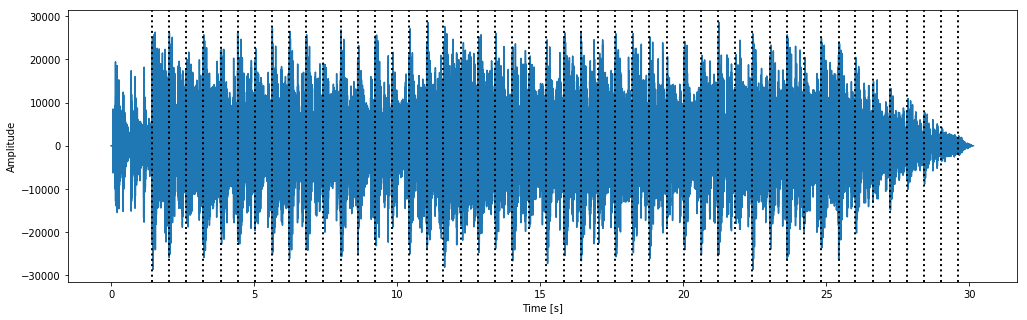

In [2]:
example = '../data/audio/Ballroom/Albums-Latin_Jam3-06.wav'
annotations_file = '../data/annotations/Ballroom/Albums-Latin_Jam3-06.beats'

sample_rate, signal = wavfile.read(example, mmap=True)
time_vector = np.linspace(0, len(signal)/sample_rate, len(signal))
annotations = madmom.io.load_onsets(annotations_file)

print('Sample rate: {} \n\
Data type: {} \n\
Minimum: {} \n\
Maximum: {}'.format(sample_rate, signal.dtype, np.min(signal), np.max(signal)))

plt.figure(figsize=(17,5))
plt.plot(time_vector, signal)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude');

for ann in annotations:
    plt.axvline(x=ann, color='k', linestyle=':', linewidth=2)

ipd.Audio(example)

## Slice audio into frames
The discrete input signal $x(n)$ is segmented into overlapping frames with sample length $W = 1024$.

Frame rate $\; f_r = 100 \;\text{Hz}$

Hop_size $\; H = \dfrac{f_s}{f_r} = \dfrac{44100\;\text{Hz}}{100\;\text{Hz}} = 441$

Number of Frames $\; N_f = \dfrac{\text{Signal length}}{H}$ = 

In [3]:
# frame_size = 1024
frame_size = 2048 * 2
frame_rate = 100
hop_size = sample_rate/frame_rate
num_frames = int(np.floor(len(signal) / float(hop_size) + 1))

print('Number of frames: {}'.format(num_frames))

def signal_frame(signal, index, frame_size, hop_size, origin=0):
    
    frame_size = int(frame_size)
    num_samples = len(signal)
    ref_sample = int(index * hop_size)
    start = ref_sample - frame_size // 2 - int(origin)
    stop = start + frame_size

    if (stop < 0) or (start > num_samples):
        # window falls completely outside the actual signal, return just zeros
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        return frame
    elif (start < 0) and (stop > num_samples):
        # window surrounds the actual signal, position signal accordingly
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:num_samples - start] = signal
        return frame
    elif start < 0:
        # window crosses left edge of actual signal, pad zeros from left
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:] = signal[:stop, ]
        return frame
    elif stop > num_samples:
        # window crosses right edge of actual signal, pad zeros from right
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[:num_samples - start] = signal[start:, ]
        return frame
    # normal read operation
    return signal[start:stop, ]

frames = []

for index in range(num_frames):
    frames.append(signal_frame(signal, index, frame_size, hop_size))

Number of frames: 3015


## Window functions

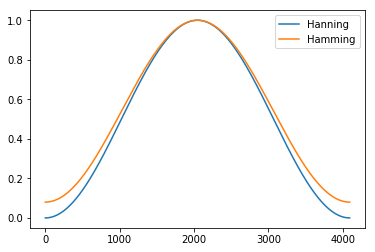

In [4]:
hanning = np.hanning(frame_size)
hamming = np.hamming(frame_size)

plt.plot(hanning)
plt.plot(hamming)
plt.legend(['Hanning', 'Hamming']);

## Calculate Short Time Fourier Transformation

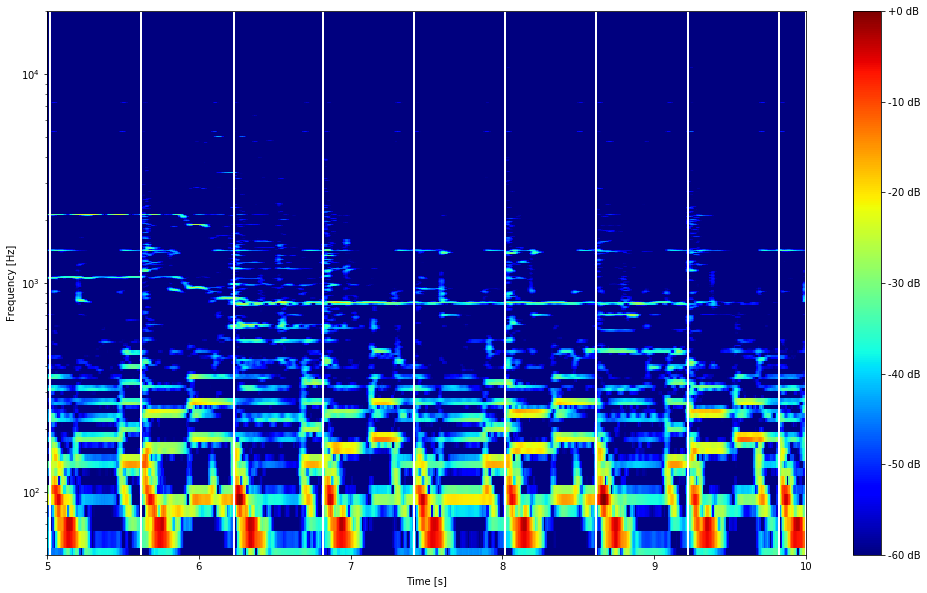

In [5]:
num_fft_bins = frame_size >> 1

window = hamming

fft = np.empty((num_frames, num_fft_bins), np.complex64)

for f, frame in enumerate(frames):
    fft_signal = np.multiply(frame, window)
    fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]
    
abs_fft = np.square(np.abs(fft))
    
bin_frequencies = np.fft.fftfreq(frame_size, 1. / sample_rate)[:num_fft_bins]

maximum = np.max(abs_fft.T)

fft_norm = abs_fft / maximum

spectrogram = fft_norm

# Define excerpt in seconds 
start = 5
end = 10
    
plt.figure(figsize=(17,10))
plt.imshow(20*np.log10(fft_norm.T[:,start*frame_rate:end*frame_rate]), 
           extent=(start,end, 0, sample_rate//2), 
           origin='lower', aspect='auto',cmap='jet', vmin=-60, vmax=0);
plt.yscale('log')
plt.ylim(50, 20000)

plt.colorbar(format='%+2.0f dB');
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]');

for ann in annotations:
    plt.axvline(x=ann, color='w', linestyle='-', linewidth=2)
    
plt.xlim(start, end)

ipd.Audio(signal[start*sample_rate:end*sample_rate], rate=sample_rate)


In [9]:
num_fft_bins

2048

## Mel Filterbank

Mel Frequencies: [   20.   139.   277.   438.   625.   843.  1097.  1394.  1738.  2140.
  2608.  3153.  3787.  4526.  5387.  6390.  7558.  8918. 10502. 12348.
 14497. 17000.]
Bins: [   2   13   26   41   58   78  102  129  161  199  242  293  352  420
  500  594  702  828  975 1147 1346 1579]


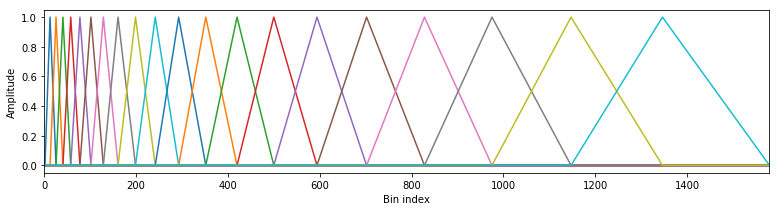

In [6]:
FILTER_DTYPE = np.float32
num_bands = 20
fmin = 20.
fmax = 17000.

def hz2mel(f):
    return 1127.01048 * np.log(np.asarray(f) / 700. + 1.)

def mel2hz(m):
    return 700. * (np.exp(np.asarray(m) / 1127.01048) - 1.)

def mel_frequencies(num_bands, fmin, fmax):
    return mel2hz(np.linspace(hz2mel(fmin), hz2mel(fmax), num_bands))

def frequencies2bins(frequencies, bin_frequencies):
    indices = bin_frequencies.searchsorted(frequencies)
    left = bin_frequencies[indices - 1]
    right = bin_frequencies[indices]
    indices -= frequencies - left < right - frequencies
    return indices

def bins2filterbank(bins, num_fft_bins):
    filterbank = []
    index = 0
    for index in range(len(bins)-2):
        start, center, end = bins[index: index + 3]
        filt = np.zeros(num_fft_bins)
        # rising edge (without the center)
        filt[start:center] = np.linspace(0, 1, center - start, endpoint=False)
        # falling edge (including the center, but without the last bin)
        filt[center:end] = np.linspace(1, 0, end - center, endpoint=False)
        filterbank.append(filt)
    return filterbank
        
frequencies = mel_frequencies(num_bands + 2, fmin, fmax)

bins = frequencies2bins(frequencies, bin_frequencies)

filterbank = bins2filterbank(bins, num_fft_bins)

print('Mel Frequencies: {}'.format(np.round(frequencies)))
print('Bins: {}'.format(bins))

plt.figure(figsize=(13,3))
for filt in filterbank:
    plt.plot(filt);
plt.xlabel('Bin index')
plt.ylabel('Amplitude')
plt.xlim([0, np.max(bins)]);

## Filtered Spectrogram 

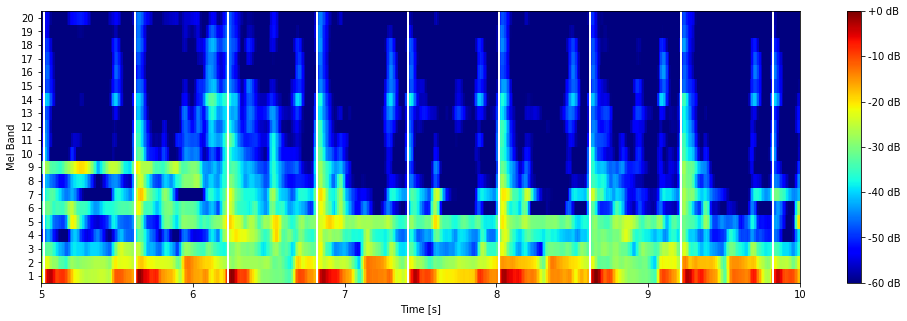

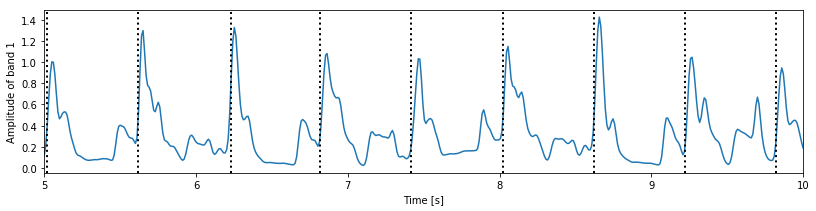

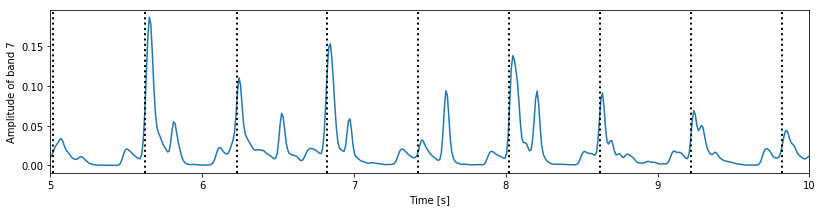

In [7]:
filterbank = np.asarray(filterbank)

filt_spec = np.dot(spectrogram, filterbank.T)

filt_spec_norm = filt_spec / np.max(filt_spec)

plt.figure(figsize=(17,5))
plt.imshow(20*np.log10(filt_spec_norm.T[:,start*frame_rate:end*frame_rate]), 
           extent=(start,end, 0.5, num_bands+0.5),
           origin='lower', aspect='auto',cmap='jet', vmin=-60, vmax=0);
plt.yticks(range(21));
plt.ylim(0.5,num_bands+0.5)

for ann in annotations:
    plt.axvline(x=ann, color='w', linestyle='-', linewidth=2)
plt.xlim(start, end)

plt.colorbar(format='%+2.0f dB');
plt.xlabel('Time [s]')
plt.ylabel('Mel Band');



pick_band = 1
plt.figure(figsize=(13.6,3))
plt.plot(np.linspace(start, end, end*frame_rate-start*frame_rate),
         filt_spec[start*frame_rate:end*frame_rate,pick_band-1])
plt.xlim(start, end)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude of band {}'.format(pick_band));

for ann in annotations:
    plt.axvline(x=ann, color='k', linestyle=':', linewidth=2)
plt.xlim(start, end)

pick_band = 7
plt.figure(figsize=(13.6,3))
plt.plot(np.linspace(start, end, end*frame_rate-start*frame_rate),
         filt_spec[start*frame_rate:end*frame_rate,pick_band-1])
plt.xlim(start, end)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude of band {}'.format(pick_band));

for ann in annotations:
    plt.axvline(x=ann, color='k', linestyle=':', linewidth=2)
plt.xlim(start, end)

ipd.Audio(signal[start*sample_rate:end*sample_rate], rate=sample_rate)



In [8]:
filt_spec.shape

(3015, 20)